In [91]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

## Load CSV

In [92]:
data=pd.read_csv('../creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Split and shuffle data

In [7]:
# time to hour interval
data['hour'] = data['Time'].apply(lambda x: np.ceil(x/3600)%24)

In [95]:
data_shuffle=data.sample(frac=1).reset_index(drop=True)
split_point=(int)(0.7*len(data))
# X_train=data_shuffle.loc[:split_point,["Amount","hour"]]
# X_test=data_shuffle.loc[split_point:,["Amount","hour"]]
data_shuffle.drop('Time', axis=1, inplace=True)
X=data_shuffle.drop('Class',axis=1, inplace=False)
Y=data_shuffle.Class
X_train=X[:split_point]
X_test=X[split_point:]
y_train=Y[:split_point]
y_test=Y[split_point:]
# print(str(len(test))+"+"+str(len(train))+"="+str(len(data)))

In [73]:
sum(y_test.Class)

166

## Metrics

### Fast auc

In [96]:

#fast auc
from numba import jit

@jit
def fast_auc(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_pred)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

### Confusion matrix

In [75]:
# ture positive
def get_TP(y_true, y_pred):
    return sum((y_true==1)&(y_pred==1))

def get_FP(y_true, y_pred):
    return sum((y_true==0)&(y_pred==1))

def get_FN():
    return sum((y_true==0)&(y_pred==0))

def get_TN():
    return sum((y_true==1)&(y_pred==0))

In [76]:
def confusion_matrix(y_true, y_pred):
    TP = get_TP(y_true, y_pred)
    FN = get_FN(y_true, y_pred)
    FP = get_FP(y_true, y_pred)
    TN = get_TN(y_true, y_pred)
    return np.array([[TN, FP],[FN, TP]])

### Accuracy

In [77]:
def accu(label,pred):
    return (get_TP(label,pred)+get_TN(label,pred))/len(label)

### Precision

In [78]:
def get_prec(label,pred):
    return get_TP(label,pred)/(get_TP(label,pred)+get_FP(label,pred))

### Recall

In [79]:
def get_recall(label,pred):
    return get_TP(label,pred)/(get_TP(label,pred)+get_FN(label,pred))

### F1

In [80]:
def get_F1(label,pred):
    return 2/(1/get_prec(label,pred)+1/get_recall(label,pred))

### Built in 

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

### Compute F1 and AUC using different weights

In [98]:
weight = list(range(5,95,5))
weight=[x/100 for x in weight]
f1_score_l=[]
auc_score_l=[]

In [99]:
for i in range(0, len(weight)):
    lr=LogisticRegression(class_weight={0:weight[i],1:(1-weight[i])})
    lr.fit(X_train,y_train)
    res=lr.predict(X_test)
    f1_score_l.append(f1_score(y_test,res))
    auc_score_l.append(roc_auc_score(y_test,res))

D:\CV_ENV\envs\cyz_py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\CV_ENV\envs\cyz_py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\CV_ENV\envs\cyz_py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\CV_ENV\envs\cyz_py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\CV_ENV\envs\cyz_py3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

In [100]:
from pandas import Series,DataFrame
w_f1=DataFrame({'weight':Series(weight),'f1':Series(f1_score_l)})
w_auc=DataFrame({'weight':Series(weight),'auc':Series(auc_score_l)})

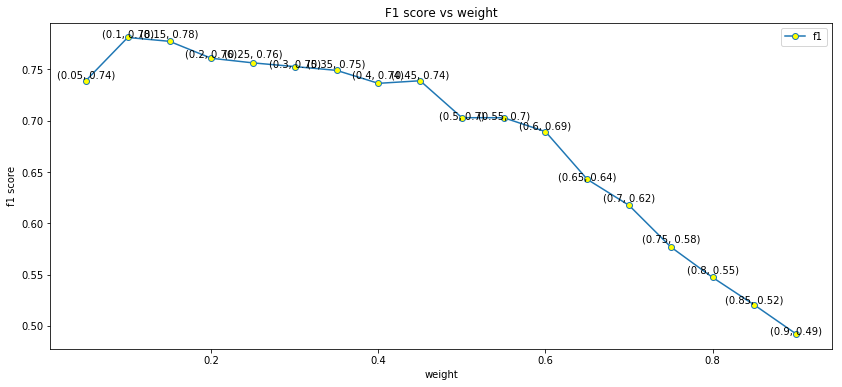

In [106]:
plt.figure(figsize=(14,6))
plt.plot(w_f1['weight'],w_f1['f1'],marker='o',markerfacecolor='yellow')
plt.title("F1 score vs weight")
plt.xlabel("weight")
plt.ylabel("f1 score")

f1_score_l=[round(x,2) for x in f1_score_l]
for a, b in zip(weight, f1_score_l):
    plt.text(a, b, (a,b), ha='center', va='bottom', fontsize=10)
plt.legend()

In [104]:
round(0.5,3)

0.5

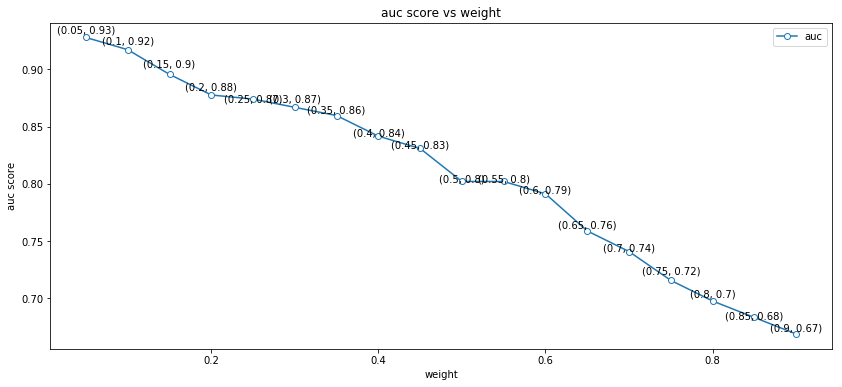

In [108]:
plt.figure(figsize=(14,6))
plt.plot(w_auc['weight'],w_auc['auc'],marker='o',markerfacecolor='white')
plt.title("auc score vs weight")
plt.xlabel("weight")
plt.ylabel("auc score")
auc_score_l=[round(x,2) for x in auc_score_l]
for a, b in zip(weight, auc_score_l):
    plt.text(a, b, (a,b), ha='center', va='bottom', fontsize=10)
plt.legend()